In [1]:
using Gen
using PyPlot
using Highlights
using Revise
include("../src/utils.jl")
include("../src/model.jl");

# Inertial dynamics

In [2]:
display_source("../src/model.jl")

using Gen 


 struct Hypers 
 accel_std :: Real 
 obs_std :: Real 
 end 

 """
Multivariate gaussian with mean 0 and stdev `accel_std`.
""" 
 @gen function dynamics_randomness ( state :: State , accel_std :: Real ) 
 rand_ax ~ normal ( 0 , accel_std ) 
 rand_ay ~ normal ( 0 , accel_std ) 
 return ( rand_ax , rand_ay ) 
 end 

 """
Multivariate gaussian with mean `center` and stdev `obs_std`.
""" 
 @gen function obs_randomness ( center :: Vec2 , obs_std :: Real ) 
 { :x } ~ normal ( center [ 1 ], obs_std ) 
 { :y } ~ normal ( center [ 2 ], obs_std ) 
 end 

 """
Simple discrete integration. Can be replaced with something like PyBullet.
""" 
 function dynamics_sim ( prev_state :: State , rand_a :: Vec2 ; const_a :: Vec2 = ( 0 , 0 ), ΔT :: Real = 1 ) 
 prev_v = prev_state . velocity 
 prev_x = prev_state . position 

 new_a = const_a + rand_a 
 new_v = prev_v + new_a * ΔT 
 new_x = prev_x + new_v * ΔT 
 new_state = State ( new_x , new_v , new_a ) 

 return new_state 
 end 

 """
Models the trajectory of a particle across `T` time steps, starting at `init_state`.
The particle is subject to `const_a` acceleration, plus a normally distributed acceleration at each time step.
The end position is then observed.
""" 
 @gen function dynamics_model ( T :: Int , init_state :: State , const_a :: Vec2 , hypers :: Hypers ) 
 # initialization 
 states = Vector { State }( undef , T + 1 ) 
 states [ 1 ] = init_state 

 # run dynamics 
 for t in 1 : T 
 # model randomness. states[t] is not used here, but in general it could be 
 rand_a = { t } ~ dynamics_randomness ( states [ t ], hypers . accel_std ) 

 # run simulation 
 states [ t + 1 ] = dynamics_sim ( states [ t ], rand_a ; const_a = const_a ) 
 end 

 # object emerges 
 final_pos = states [ end ] . position 
 { :obs } ~ obs_randomness ( final_pos , hypers . obs_std ) 

 return states 
 end

### Examining a trace
The object is initialized with a velocity traveling to the right, with no constant forces acting on it.

In [3]:
# model arguments
T = 5
shot_forward = State((-0.1,0),(0.3,0),(0,0))
no_const_accel = (0,0)
hypers = Hypers(0.03, 0.03)
model_args = (T, shot_forward, no_const_accel, hypers)

# observed end point
obs_x = 1.2
obs_y = 0.3
constraints = Gen.choicemap()
constraints[:obs => :x] = obs_x
constraints[:obs => :y] = obs_y

tr, = Gen.generate(dynamics_model, model_args, constraints)

display(Gen.get_choices(tr))

│
├── 5
│   │
│   ├── :rand_ax : 0.03782314664498387
│   │
│   └── :rand_ay : 0.02232201554022025
│
├── 4
│   │
│   ├── :rand_ax : 0.038916669473097826
│   │
│   └── :rand_ay : 0.005374245218691356
│
├── 2
│   │
│   ├── :rand_ax : 0.024207357108695975
│   │
│   └── :rand_ay : -0.03264792947930266
│
├── :obs
│   │
│   ├── :y : 0.3
│   │
│   └── :x : 1.2
│
├── 3
│   │
│   ├── :rand_ax : -0.022933411336374818
│   │
│   └── :rand_ay : 0.02057254492648862
│
└── 1
    │
    ├── :rand_ax : 0.009025988267348862
    │
    └── :rand_ay : 0.013954263772714064


# Plotting the Prior

We plot 100 trajectories from the prior

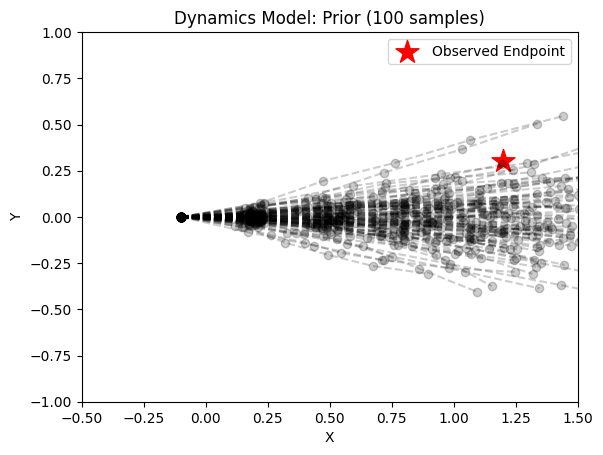

In [4]:
num_traces_to_visualize = 100
fig1, ax = init_occluder_scene((obs_x, obs_y), "Prior ($num_traces_to_visualize samples)")
prior_traces = [first(Gen.generate(dynamics_model, model_args, constraints)) for _ in 1:num_traces_to_visualize]
(tr -> draw_trace!(ax, tr)).(prior_traces);

# Inference (Importance Sampling)

We run simple importance sampling with 10,000 samples, and visualize 100 samples from the approximate posterior.

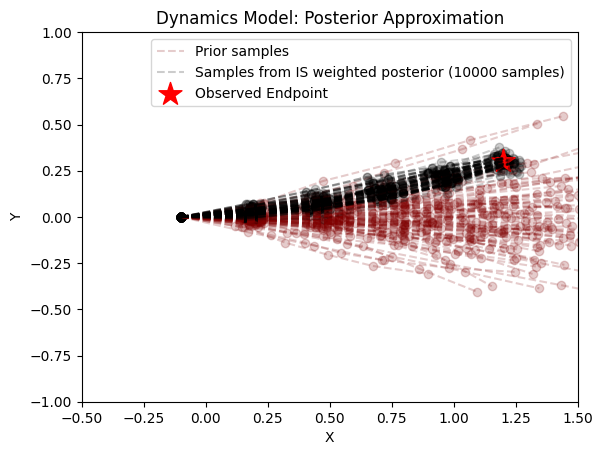

In [5]:
num_top_traces_to_visualize = 100
num_is_samples = 10000
fig2, ax = init_occluder_scene((obs_x, obs_y), "Posterior Approximation")
(post_traces, log_norm_weights, lml_est) = importance_sampling(dynamics_model, model_args, constraints, num_is_samples)
probs = exp.(log_norm_weights)
lines, = (tr -> draw_trace!(ax, tr; color="maroon")).(prior_traces)
lines[end].set_label("Prior samples")
lines, = (tr -> draw_trace!(ax, tr; color="black")).(post_traces[[categorical(probs) for _ in 1:100]])
lines[end].set_label("Samples from IS weighted posterior ($num_is_samples samples)")
ax.legend()
ax.scatter(obs_x, obs_y, s=300, marker="*", c="red", label="Observed Endpoint");

# Additional Example Inference Procedure (MCMC)

This section can be skipped, since we seem to do really well with just IS, but for more complex trajectories we may want to perform some MCMC.

First we define a _path diffusion kernel_ that does `3*T` block samples across random time steps, with a gaussian drift proposal with std = 0.01.

In [6]:
@gen function random_walk_proposal(tr, addrs::Vector{<:Any}, width)
    for addr in addrs
        {addr} ~ normal(tr[addr], width)
    end
end

random_walk_kernel(trace, addr, width) = mh(trace, random_walk_proposal, (addr, width))[1]

function path_diffusion_kern(trace)
    # cycle through the timesteps, and do a random-walk update on each intermediate state.
    T, = get_args(trace)
    # T = args[1]
    for rep in 1:3*T
        let t = uniform_discrete(1, T)
            trace, = mh(trace, random_walk_proposal, ([t => :rand_ax, t => :rand_ay], 0.01))
        end
    end
    return trace
end;

Next we burn in Markov chain, and visualize 100 time steps from the converged chain.

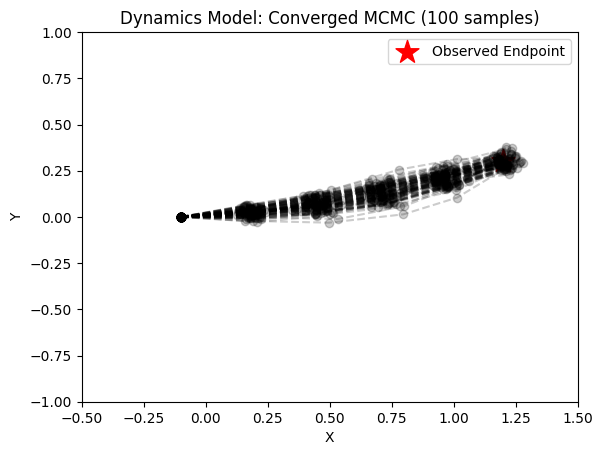

In [7]:
num_sampled_traces = 100
burn_in = 1000

fig, ax = init_occluder_scene((obs_x, obs_y), "Converged MCMC ($num_sampled_traces samples)")

# burn in
tr, = Gen.generate(dynamics_model, model_args, constraints)
for _ in 1:1000
    global tr
    tr = path_diffusion_kern(tr)
end

# sample and visualize the chain
for _ in 1:num_sampled_traces
    delay = poisson(20)
    for _ in 1:delay
        global tr
        tr = path_diffusion_kern(tr)
    end
    draw_trace!(ax, tr)
end